For viewing individual dataset.

In [4]:
import numpy as np  
import matplotlib.pyplot as plt  
import h5py

In [5]:
# Load h5py file
example_dt = h5py.File('./BraTS2020_training_data/content/data/volume_5_slice_100.h5','r')

In [6]:
# see what is inside that h5 file
print(example_dt.keys())

<KeysViewHDF5 ['image', 'mask']>


In [7]:
image = example_dt['image']
print(image.shape)
mask = example_dt['mask']
print(mask.shape)
mask = np.dstack((np.sum(mask,axis=2)==0,mask))
print(mask.shape)

(240, 240, 4)
(240, 240, 3)
(240, 240, 4)


In [19]:
import numpy as np
a = np.empty(1,dtype='float64')
print(a.nbytes)
a = np.random.randint(1,369,14)
print(np.sort(a))

8
[ 23  43  50  89 123 132 197 208 218 221 284 285 318 321]


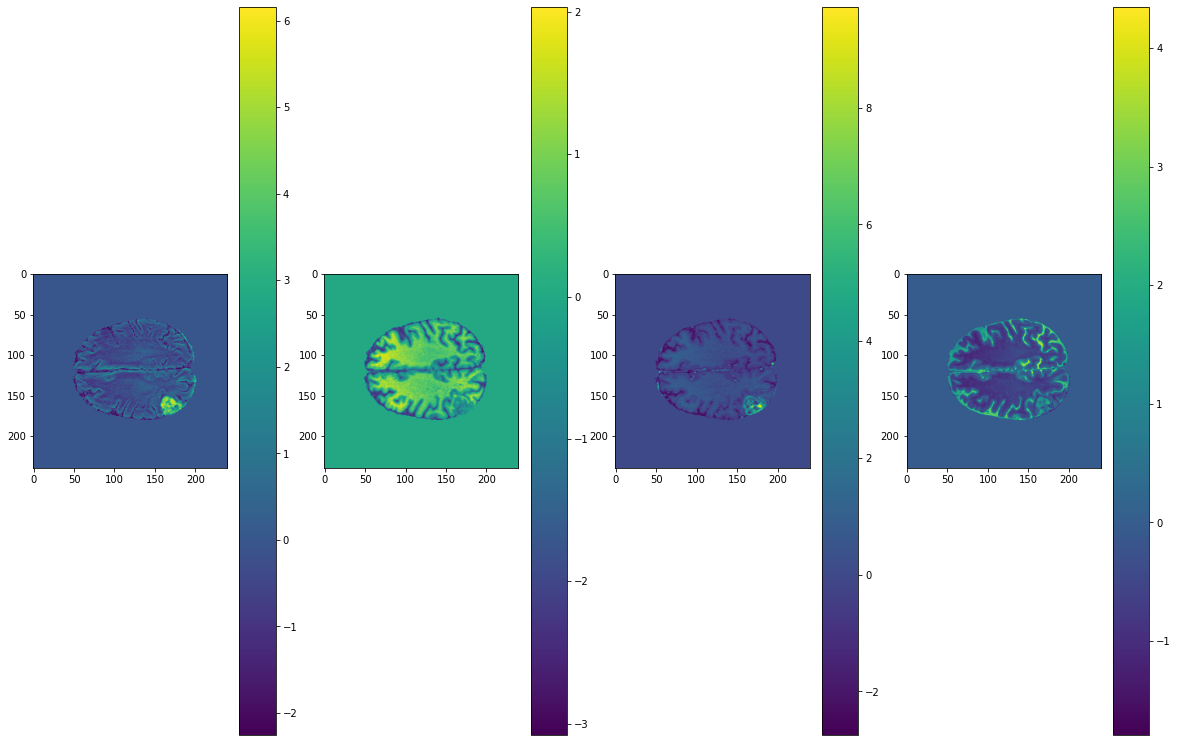

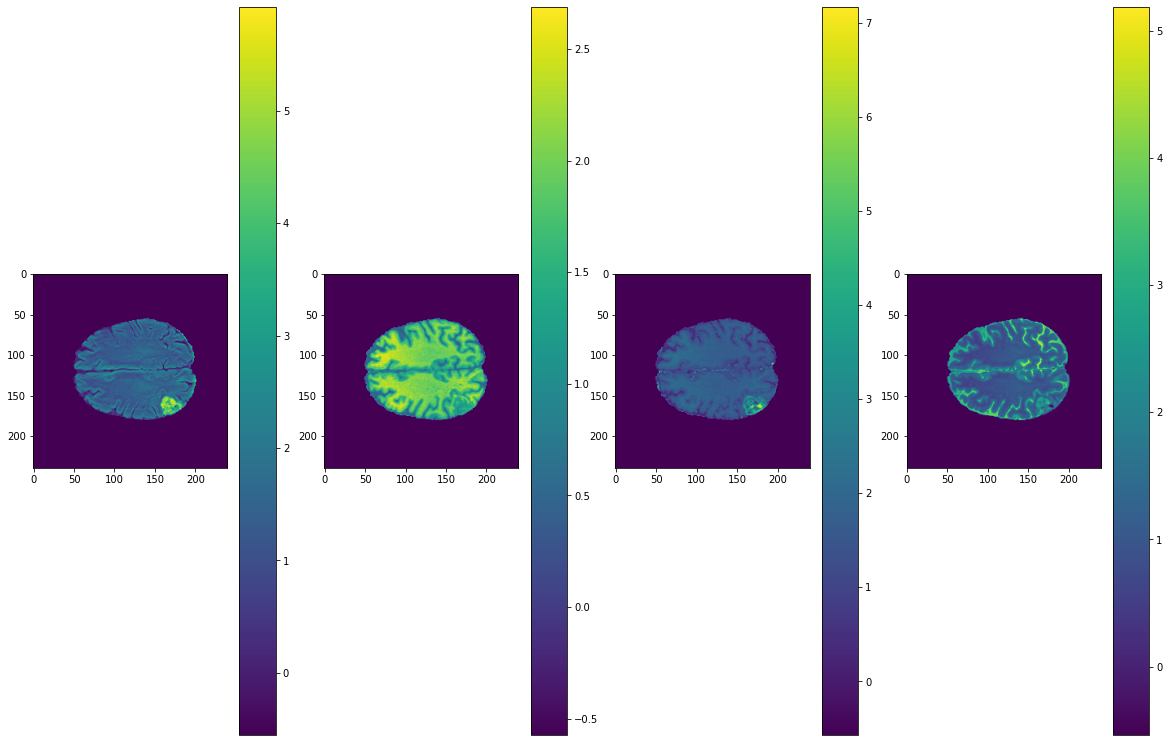

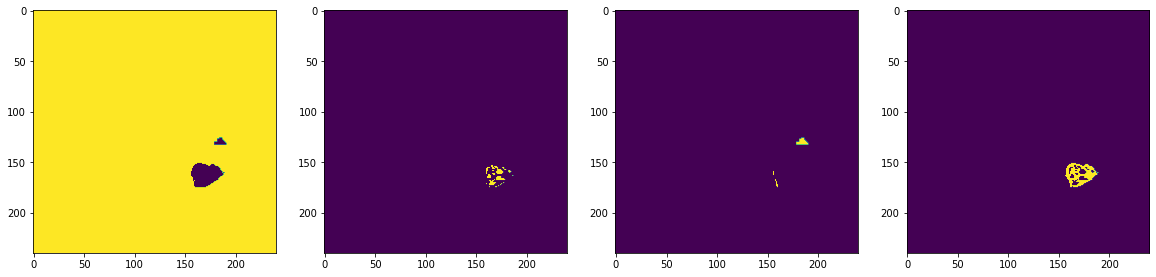

In [118]:
imageNorm = image[()]
imageNorm[imageNorm<0] = np.nan
imageNorm = (imageNorm - np.nanmean(imageNorm,axis=(0,1)))/np.nanstd(imageNorm,axis=(0,1))
imageNorm[np.isnan(imageNorm)]=0
plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = imageNorm[:,:,i]
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
    plt.colorbar()
plt.show()
"""
plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = image[:,:,i]
    img_np[np.nonzero(img_np<0)] = 0
    print(np.mean(img_np[img_np>0]))
    print(np.std(img_np[img_np>0]))
    img_np[img_np>0] = (img_np[img_np>0] - np.mean(img_np[img_np>0]))/np.std(img_np[img_np>0])
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
    plt.colorbar()
plt.show()
"""
plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = image[:,:,i]
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
    plt.colorbar()
plt.show()

plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = mask[:,:,i]
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
"""
plt.subplot(1,4,4)
img_np = mask[:,:,0] + mask[:,:,1]*2 + mask[:,:,2]*3
plt.imshow(img_np)
"""
plt.show()

Fixed seed for reproducibility (not bootstrapping the test set and keeping it independent). Loads the data and readies the indices for training, validation, test split

lazily loads or loads into RAM, defers normalization to GPU (main dataset class)

In [1]:
import h5py
import gc
import numpy as np
from pathlib import Path
import torch
from torch.utils import data

# taken from https://towardsdatascience.com/hdf5-datasets-for-pytorch-631ff1d750f5

class HDF5Dataset(data.Dataset):
    def __init__(self, file_path, load_ram=False):
        # Search for all h5 files
        self.load_ram = load_ram
        p = Path(file_path)
        assert(p.is_dir())
        self.files = sorted(p.glob('*.h5'))
        if len(self.files) < 1:
            raise RuntimeError('No hdf5 datasets found')
        self.len = len(self.files)
        if load_ram:
            data_path = str(self.files[0].resolve())
            x, y = h5py.File(data_path).items()
            self.data_x = np.empty((self.len,)+x[1][()].shape)
            self.data_y = np.empty((self.len,)+y[1][()].shape,dtype='uint8')
            for index, filepath in enumerate(self.files):
                data_path = str(filepath.resolve())
                x, y = h5py.File(data_path).items()
                self.data_x[index,:,:,:] = torch.from_numpy(x[1][()])
                self.data_y[index,:,:,:] = torch.from_numpy(y[1][()])
            
    def __getitem__(self, index):
        if self.load_ram:
            return (self.data_x[index,:,:,:], self.data_y[index,:,:,:])
        
        # x is image, y is mask
        data_path = str(self.files[index].resolve())
        x, y = h5py.File(data_path).items()
        x = torch.from_numpy(x[1][()])
        y = torch.from_numpy(y[1][()])
        return (x, y)
        #return (x.permute(2,0,1), y.permute(2,0,1))
            
    def __len__(self):
        return self.len

In [2]:
# debug testing the class on a smaller subset
device = torch.device("cuda:0")
subsetTest = HDF5Dataset('./BraTS2020_training_data/content/data',False)

In [3]:
import torchvision

class mriDataAugment(data.Dataset):
    """
    Transforms the training dataset for data augmentation purposes
    """
    def __init__(self, dataset, transform = []):
        self.dataset = dataset
        self.transform = transform
        self.transform_len = len(transform)
        self.data_len = len(self.dataset)
        self.len = (len(transform)+1)*len(self.dataset)
        
    def __getitem__(self, idx):
        data_idx = idx % self.data_len
        trans_idx = idx // self.data_len
        # ensures first image is not transformed
        if trans_idx == 0:
            sample, target = self.dataset[data_idx]
            return sample, target
        else:
            dim_s, dim_t = self.dataset[data_idx][0].shape[2], self.dataset[data_idx][1].shape[2]
            data = torch.cat(self.dataset[data_idx],dim=2)
            data = self.transform[trans_idx-1](data.permute(2,0,1))
            """
            try:
                data = self.transform[trans_idx-1](data.permute(2,0,1))
            except:
                data = data.permute(2,0,1)
                for i in range(data.shape[0]):
                    data[i,:,:] = self.transform[trans_idx-1](data[i,:,:])
            """
            sample, target = torch.split(data,[dim_s,dim_t])
            #target[0,:,:] = torch.sum(target[1:4,:,:],axis=0)==0
            return sample.permute(1,2,0), target.permute(1,2,0)
        
    def __len__(self):
        return self.len

In [3]:
import torchvision
import torchvision.transforms.functional as TF
seedNb = 20985464
totalLen = subsetTest.__len__()
# create 70/15/15 split
trainSz = round(totalLen*0.7)
valSz = round((totalLen-trainSz)/2)
testSz = totalLen-trainSz-valSz
trainSet, valSet, testSet = torch.utils.data.random_split(subsetTest, [trainSz, valSz, testSz], generator=torch.Generator().manual_seed(seedNb))
#transforms=[torchvision.transforms.Lambda(lambda img: TF.adjust_gamma(img,gamma=1))]
#transforms=[torchvision.transforms.RandomPerspective(p=1)]
#trainAugSet = mriDataAugment(trainSet,transforms)
#trainSetLoader = torch.utils.data.DataLoader(trainAugSet, batch_size=32, shuffle=False, pin_memory=True)
trainSetLoader = torch.utils.data.DataLoader(trainSet, batch_size=24, shuffle=True, pin_memory=True)
valSetLoader = torch.utils.data.DataLoader(valSet, batch_size=24, shuffle=False, pin_memory=True)
testSetLoader = torch.utils.data.DataLoader(testSet, batch_size=24, shuffle=False, pin_memory=True)

In [5]:
import matplotlib.pyplot as plt

idx=20
idxb=1
idy=(trainSz+idx)%32
idyb=(trainSz+idx)//32+idxb
for batch, (X,y) in enumerate(trainSetLoader):
    if batch==idxb:
        X,y = data_preprocess(X.permute(0,3,1,2).to(memory_format=torch.contiguous_format),
                              y.permute(0,3,1,2).to(memory_format=torch.contiguous_format))
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(X[idx,i,:,:])
        plt.show()
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(y[idx,i,:,:])
        plt.show()
        
    if batch==idyb:
        X,y = data_preprocess(X.permute(0,3,1,2).to(memory_format=torch.contiguous_format),
                              y.permute(0,3,1,2).to(memory_format=torch.contiguous_format))
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(X[idy,i,:,:])
        plt.show()
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(y[idy,i,:,:])
        plt.show()
        break

In [4]:
# unet model from https://github.com/milesial/Pytorch-UNet
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, n_features=16, n_layers=4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.n_features = n_features
        self.n_layers = n_layers
        self.downList = nn.ModuleList()
        self.upList = nn.ModuleList()

        self.inc = DoubleConv(n_channels, n_features)
        cntDown = 1
        cntUp = 2**n_layers
        factor = 2 if bilinear else 1
        for i in range(n_layers):
            if i == n_layers-1:
                self.downList.append(Down(n_features*cntDown,n_features*cntDown*2//factor))
                self.upList.append(Up(n_features*2,n_features,bilinear))
            else:
                self.downList.append(Down(n_features*cntDown,n_features*cntDown*2))
                self.upList.append(Up(int(n_features*cntUp),int(n_features*cntUp/2//factor),bilinear))
            cntDown *= 2
            cntUp /= 2
        self.outc = OutConv(n_features, n_classes)

    def forward(self, x):
        xn = []
        xn.append(self.inc(x))
        for i in range(self.n_layers):
            xn.append(self.downList[i](xn[i]))
        for i in range(self.n_layers):
            if i == 0:
                x = self.upList[i](xn[self.n_layers],xn[self.n_layers-1])
            else:
                x = self.upList[i](x,xn[self.n_layers-i-1])
        logits = self.outc(x)
        return logits

In [5]:
device = torch.device("cuda:0")
model = UNet(4,4,True,39,4).to(device)

In [6]:
import torch
from torch import Tensor

# from https://github.com/milesial/Pytorch-UNet

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [7]:
def data_aug(image,mask,transform):
    # do this before preprocess due to rotation and scaling padding
    if image.dim() == 3:
        data = torch.cat((image,mask))
        dim_i, dim_m = image.shape[0], mask.shape[0]
        data = transform(data)
        image, mask = torch.split(data,[dim_i,dim_m])
    elif image.dim() == 4:
        data = torch.cat((image,mask),dim=1)
        dim_i, dim_m = image.shape[1], mask.shape[1]
        data = transform(data)
        image, mask = torch.split(data,[dim_i,dim_m],dim=1)
    return image, mask

In [8]:
def data_preprocess(image,mask=None):
    # checks if there's a batch dimension
    n_dim = image.dim()
    
    if n_dim == 4:
        # w/ batches BCHW
        norm_axis = (2,3)
        bkgd_axis = 1
    elif n_dim == 3:
        # no batches CHW
        norm_axis = (1,2)
        bkgd_axis = 0
    else:
        raise ValueError(f'Wrong number of dimensions {n_dim}')
    # normalizes data by subtracting mean and dividing by std
    image[image<=0] = float('nan')
    mean = torch.nanmean(image,axis=norm_axis).unsqueeze(2).unsqueeze(2)
    image = (image - mean)/torch.sqrt(torch.nansum((image-mean)**2,axis=norm_axis)/
                                      torch.sum(~torch.isnan(image),axis=norm_axis)).unsqueeze(2).unsqueeze(2)
    image[torch.isnan(image)] = 0
    if mask is None:
        return image
    # adds background mask
    mask = torch.cat(((torch.sum(mask,axis=bkgd_axis)==0).unsqueeze(bkgd_axis),mask),dim=bkgd_axis)    
    """
    if n_dim == 4:
        # w/ batches BHWC
        norm_axis = (1,2)
        bkgd_axis = 3
    elif n_dim == 3:
        # no batches HWC
        norm_axis = (0,1)
        bkgd_axis = 2
    else:
        raise ValueError(f'Wrong number of dimensions {n_dim}')
    
    # normalizes data by subtracting mean and dividing by std
    image[image<=0] = float('nan')
    mean = torch.nanmean(image,axis=norm_axis).unsqueeze(1).unsqueeze(1)
    image = (image - mean)/torch.sqrt(torch.nansum((image-mean)**2,axis=norm_axis)/
                                      torch.sum(~torch.isnan(image),axis=norm_axis)).unsqueeze(1).unsqueeze(1)
    image[torch.isnan(image)] = 0
    if mask == None:
        if n_dim == 4:
            return image.permute(0,3,1,2).to(memory_format=torch.contiguous_format)
        return image.permute(2,0,1).to(memory_format=torch.contiguous_format)
    # adds background mask
    mask = torch.cat(((torch.sum(mask,axis=bkgd_axis)==0).unsqueeze(bkgd_axis),mask),dim=bkgd_axis)
    
    if n_dim == 4:
        return image.permute(0,3,1,2).to(memory_format=torch.contiguous_format),mask.permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    return image.permute(2,0,1).to(memory_format=torch.contiguous_format), mask.permute(2,0,1).to(memory_format=torch.contiguous_format)
    """
    return image, mask

In [9]:
#import time
def train_loop(dataloader, model, optimizer,grad_scaler,transforms=[]):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    current = 0
    for batch, (X, y) in enumerate(dataloader):
        #t = time.time()
        # Compute prediction and loss
        # Send to GPU first
        loss_avg = 0
        X = X.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
        y = y.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
        image, mask = data_preprocess(X,y)
        pred = model(image)
        loss = dice_loss(pred.softmax(1),mask,multiclass=True)
        loss_avg += loss
        current += len(image)
        
        # Backpropagation
        optimizer.zero_grad()
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        # for function based data augmentation
        for transform in transforms:
            image, mask = data_aug(X,y,transform)
            image, mask = data_preprocess(image,mask)
            pred = model(image)
            loss = dice_loss(pred.softmax(1),mask,multiclass=True)
            loss_avg += loss
            
            # Backpropagation
            optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        #if batch % size != 0:
        loss_avg = loss_avg.item()/(len(transforms)+1)
        train_loss += loss_avg
        #elapsed = time.time() - t
        #print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}] time elapsed: {elapsed:>5f}")
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    return train_loss/num_batches
            
def test_loop(dataloader, model, batchIdx=None):
    size = 0
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            image = X.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
            mask = y.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
            image, mask = data_preprocess(image,mask)
            pred = model(image)
        
            test_loss_tmp = dice_loss(pred.softmax(1), mask,multiclass=True).item()
            test_loss += test_loss_tmp
            correct_tmp = (pred.argmax(1) == mask.argmax(1)).type(torch.float).sum().item()
            correct += correct_tmp
            size_tmp = pred.shape[0]*pred.shape[2]*pred.shape[3]
            size += size_tmp
            
            if batchIdx is not None and batch == batchIdx:
                print(f"Test Error: \n Accuracy: {(100*correct_tmp/size_tmp):>0.1f}%, Avg loss: {test_loss_tmp:>8f} \n")
                return pred, test_loss_tmp, correct_tmp/size_tmp
    model.train()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-8, momentum=0.9)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005931717982963994)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
transforms=[torchvision.transforms.RandomRotation(90),TF.vflip,torchvision.transforms.RandomResizedCrop(240),
           torchvision.transforms.RandomPerspective(p=1)]
#transforms=[torchvision.transforms.RandomRotation(90),TF.vflip,torchvision.transforms.RandomResizedCrop(240)]

device = torch.device("cuda:0")
epochs = 50
train_loss_track = np.zeros(epochs)
test_loss_track = np.zeros(epochs)
best_loss = 1
cnt_conv = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------")
    train_loss = train_loop(trainSetLoader,model,optimizer,grad_scaler,transforms)
    train_loss_track[t] = train_loss
    test_loss = test_loop(valSetLoader, model)
    test_loss_track[t] = test_loss
    scheduler.step(test_loss)
    if best_loss > test_loss:
        best_loss = test_loss
        cnt_conv = 0
        model_best_weights = model.state_dict()
    elif best_loss < test_loss:
        cnt_conv += 1
        if cnt_conv > 3:
            print("Early Stop!")
            model.load_state_dict(model_best_weights)
            torch.save(model_best_weights, 'unet_weights_best_param_early_stop.pth')
            break

torch.save(model_best_weights, 'unet_weights_best_param.pth')
print("Done!")
torch.cuda.empty_cache()

Epoch 1
--------------------
loss: 0.868668 [   24/40036]
loss: 0.818143 [   48/40036]
loss: 0.812563 [   72/40036]
loss: 0.798377 [   96/40036]
loss: 0.787256 [  120/40036]
loss: 0.775484 [  144/40036]
loss: 0.779986 [  168/40036]
loss: 0.775912 [  192/40036]
loss: 0.771656 [  216/40036]
loss: 0.759736 [  240/40036]
loss: 0.765526 [  264/40036]
loss: 0.781682 [  288/40036]
loss: 0.726527 [  312/40036]
loss: 0.738710 [  336/40036]
loss: 0.660088 [  360/40036]
loss: 0.695899 [  384/40036]
loss: 0.686201 [  408/40036]
loss: 0.644944 [  432/40036]
loss: 0.638393 [  456/40036]
loss: 0.652165 [  480/40036]
loss: 0.634999 [  504/40036]
loss: 0.554102 [  528/40036]
loss: 0.543600 [  552/40036]
loss: 0.506696 [  576/40036]
loss: 0.593101 [  600/40036]
loss: 0.515516 [  624/40036]
loss: 0.553069 [  648/40036]
loss: 0.537790 [  672/40036]
loss: 0.477423 [  696/40036]
loss: 0.496686 [  720/40036]
loss: 0.459474 [  744/40036]
loss: 0.486905 [  768/40036]
loss: 0.450765 [  792/40036]
loss: 0.416664

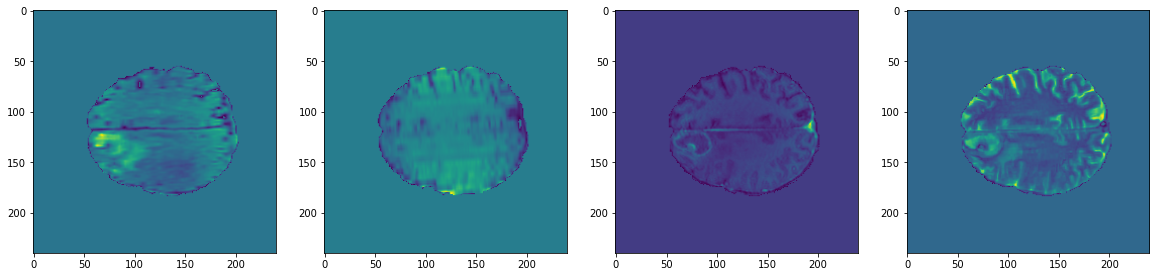

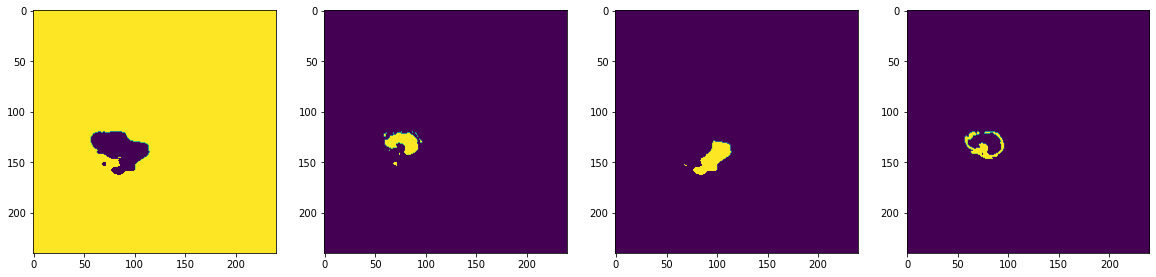

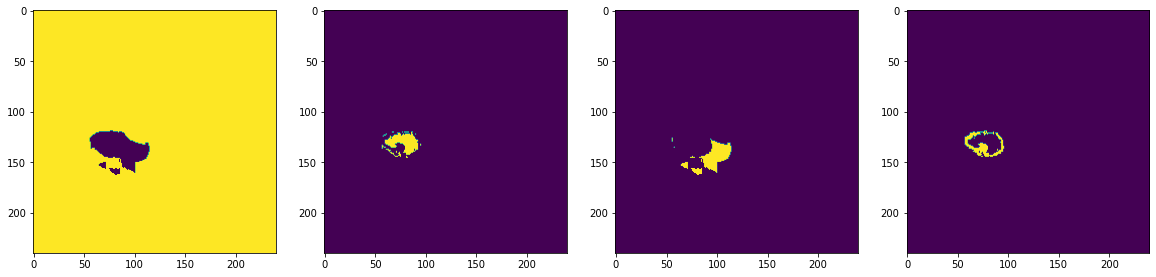

In [21]:
import matplotlib.pyplot as plt
for X, y in valSetLoader:
    image = X.to(device).permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    image = image.float()
    y = y.permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    image,y = data_preprocess(image,y)
    model.eval()
    sample = model(image)
    model.train()
    sample = sample.argmax(1)
    
    batchidx = 1
    plt.subplots(1,4,figsize = (20,20))
    for i in range(4):
        img_np = image[batchidx,i,:,:].cpu().detach().numpy()
        plt.subplot(1,4,1+i)
        plt.imshow(img_np)
    plt.show()
    
    plt.subplots(1,4,figsize = (20,20))
    for i in range(4):
        img_np = sample[batchidx,:,:].cpu().detach().numpy()
        img_np = img_np==i
        plt.subplot(1,4,1+i)
        plt.imshow(img_np)
    plt.show()
        
    plt.subplots(1,4,figsize = (20,20))
    for i in range(4):
        img_np = y[batchidx,i,:,:].detach().numpy()
        plt.subplot(1,4,1+i)
        plt.imshow(img_np)
    plt.show()
    torch.cuda.empty_cache()
    break

In [ ]:
# hyperparameter optimization
import optuna
import torch.optim as optim
import joblib

def objective(trial):

    params = {'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_features': trial.suggest_int("n_features", 16, 64),
              'n_layers': trial.suggest_int("n_layers",3,4)}
    
    torch.cuda.empty_cache()
    device = torch.device("cuda:0")
    model = UNet(4,4,bilinear=True,n_features=params["n_features"],n_layers=params["n_layers"]).to(device)
    
    optimizer = getattr(optim, params["optimizer"])(model.parameters(), lr=params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
    
    best_loss = 1
    cnt_conv = 0
    for t in range(epochs):
        print(f"Epoch {t+1}\n--------------------")
        train_loop(trainSetLoader,model,optimizer,grad_scaler,transforms)
        dice_loss = test_loop(valSetLoader, model)
        scheduler.step(dice_loss)
        trial.report(dice_loss,t)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
        if best_loss > dice_loss:
            best_loss = dice_loss
            cnt_conv = 0
            best_weights = model.state_dict()
        elif best_loss < dice_loss:
            cnt_conv += 1
            if cnt_conv > 3:
                early_stop = True
                print("Early Stop")
                torch.save(best_weights, 'unet_weights_trial' + str(trial.number) + '_early_stop.pth')
                return dice_loss        
        
    model_str = 'model_weights_trial' + str(trial.number) + '.pth'
    torch.save(model.state_dict(), model_str)
    return dice_loss

epochs = 20
device = torch.device("cuda:0")
transforms=[torchvision.transforms.RandomRotation(90),TF.vflip,torchvision.transforms.RandomResizedCrop(240),
           torchvision.transforms.RandomPerspective(p=1)]
study = optuna.create_study(study_name="unet", direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30, gc_after_trial=True)
joblib.dump(study, "study.pkl")

print("Done!")
torch.cuda.empty_cache()

[I 2022-02-11 18:11:11,601] A new study created in memory with name: unet


Epoch 1
--------------------
loss: 0.755258 [   24/ 1519]
loss: 0.725638 [   48/ 1519]
loss: 0.659729 [   72/ 1519]
loss: 0.583260 [   96/ 1519]
loss: 0.578507 [  120/ 1519]
loss: 0.596583 [  144/ 1519]
loss: 0.550245 [  168/ 1519]
loss: 0.575847 [  192/ 1519]
loss: 0.575720 [  216/ 1519]
loss: 0.586882 [  240/ 1519]
loss: 0.545073 [  264/ 1519]
loss: 0.556790 [  288/ 1519]
loss: 0.542528 [  312/ 1519]
loss: 0.498086 [  336/ 1519]
loss: 0.630762 [  360/ 1519]
loss: 0.515771 [  384/ 1519]
loss: 0.562287 [  408/ 1519]
loss: 0.524217 [  432/ 1519]
loss: 0.379302 [  456/ 1519]
loss: 0.324051 [  480/ 1519]
loss: 0.355462 [  504/ 1519]
loss: 0.445519 [  528/ 1519]
loss: 0.273960 [  552/ 1519]
loss: 0.387076 [  576/ 1519]
loss: 0.307282 [  600/ 1519]
loss: 0.302986 [  624/ 1519]
loss: 0.252831 [  648/ 1519]
loss: 0.261770 [  672/ 1519]
loss: 0.445325 [  696/ 1519]
loss: 0.363277 [  720/ 1519]
loss: 0.282347 [  744/ 1519]
loss: 0.231045 [  768/ 1519]
loss: 0.249982 [  792/ 1519]
loss: 0.339942

loss: 0.154728 [  384/ 1519]
loss: 0.229969 [  408/ 1519]
loss: 0.207433 [  432/ 1519]
loss: 0.199589 [  456/ 1519]
loss: 0.192882 [  480/ 1519]
loss: 0.287245 [  504/ 1519]
loss: 0.198888 [  528/ 1519]
loss: 0.211040 [  552/ 1519]
loss: 0.197396 [  576/ 1519]
loss: 0.254540 [  600/ 1519]
loss: 0.231507 [  624/ 1519]
loss: 0.180503 [  648/ 1519]
loss: 0.150979 [  672/ 1519]
loss: 0.182347 [  696/ 1519]
loss: 0.110535 [  720/ 1519]
loss: 0.169196 [  744/ 1519]
loss: 0.132777 [  768/ 1519]
loss: 0.150560 [  792/ 1519]
loss: 0.223569 [  816/ 1519]
loss: 0.206846 [  840/ 1519]
loss: 0.178110 [  864/ 1519]
loss: 0.178209 [  888/ 1519]
loss: 0.165517 [  912/ 1519]
loss: 0.174998 [  936/ 1519]
loss: 0.273435 [  960/ 1519]
loss: 0.222998 [  984/ 1519]
loss: 0.384897 [ 1008/ 1519]
loss: 0.280710 [ 1032/ 1519]
loss: 0.227886 [ 1056/ 1519]
loss: 0.189703 [ 1080/ 1519]
loss: 0.194400 [ 1104/ 1519]
loss: 0.195651 [ 1128/ 1519]
loss: 0.200799 [ 1152/ 1519]
loss: 0.168390 [ 1176/ 1519]
loss: 0.150486

loss: 0.228839 [  768/ 1519]
loss: 0.169119 [  792/ 1519]
loss: 0.143026 [  816/ 1519]
loss: 0.122689 [  840/ 1519]
loss: 0.209928 [  864/ 1519]
loss: 0.235018 [  888/ 1519]
loss: 0.236138 [  912/ 1519]
loss: 0.158183 [  936/ 1519]
loss: 0.142597 [  960/ 1519]
loss: 0.185288 [  984/ 1519]
loss: 0.157466 [ 1008/ 1519]
loss: 0.219683 [ 1032/ 1519]
loss: 0.206613 [ 1056/ 1519]
loss: 0.204103 [ 1080/ 1519]
loss: 0.207507 [ 1104/ 1519]
loss: 0.166679 [ 1128/ 1519]
loss: 0.164771 [ 1152/ 1519]
loss: 0.120746 [ 1176/ 1519]
loss: 0.159902 [ 1200/ 1519]
loss: 0.248584 [ 1224/ 1519]
loss: 0.132694 [ 1248/ 1519]
loss: 0.122294 [ 1272/ 1519]
loss: 0.236499 [ 1296/ 1519]
loss: 0.188561 [ 1320/ 1519]
loss: 0.157618 [ 1344/ 1519]
loss: 0.158977 [ 1368/ 1519]
loss: 0.186913 [ 1392/ 1519]
loss: 0.184352 [ 1416/ 1519]
loss: 0.148036 [ 1440/ 1519]
loss: 0.150720 [ 1464/ 1519]
loss: 0.129865 [ 1488/ 1519]
loss: 0.202243 [ 1512/ 1519]
loss: 0.258074 [ 1519/ 1519]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.

loss: 0.166563 [ 1152/ 1519]
loss: 0.164635 [ 1176/ 1519]
loss: 0.224228 [ 1200/ 1519]
loss: 0.188954 [ 1224/ 1519]
loss: 0.201830 [ 1248/ 1519]
loss: 0.131402 [ 1272/ 1519]
loss: 0.140464 [ 1296/ 1519]
loss: 0.271369 [ 1320/ 1519]
loss: 0.137906 [ 1344/ 1519]
loss: 0.190407 [ 1368/ 1519]
loss: 0.140882 [ 1392/ 1519]
loss: 0.153910 [ 1416/ 1519]
loss: 0.142723 [ 1440/ 1519]
loss: 0.121133 [ 1464/ 1519]
loss: 0.184221 [ 1488/ 1519]
loss: 0.194697 [ 1512/ 1519]
loss: 0.225153 [ 1519/ 1519]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.149006 

Epoch 14
--------------------
loss: 0.142990 [   24/ 1519]
loss: 0.191919 [   48/ 1519]
loss: 0.133248 [   72/ 1519]
loss: 0.220699 [   96/ 1519]
loss: 0.163386 [  120/ 1519]
loss: 0.165864 [  144/ 1519]
loss: 0.200436 [  168/ 1519]
loss: 0.104111 [  192/ 1519]
loss: 0.150956 [  216/ 1519]
loss: 0.217674 [  240/ 1519]
loss: 0.138834 [  264/ 1519]
loss: 0.173921 [  288/ 1519]
loss: 0.305302 [  312/ 1519]
loss: 0.184506 [  336/ 1519]
loss: 0.152286 [  3

loss: 0.265636 [ 1519/ 1519]


[I 2022-02-11 18:23:00,435] Trial 0 finished with value: 0.17430316550391062 and parameters: {'learning_rate': 0.05216074184337187, 'optimizer': 'Adam', 'n_features': 25, 'n_layers': 3}. Best is trial 0 with value: 0.17430316550391062.


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.174303 

Early Stop
Epoch 1
--------------------
loss: 0.879948 [   24/ 1519]
loss: 0.882121 [   48/ 1519]
loss: 0.874924 [   72/ 1519]
loss: 0.878059 [   96/ 1519]
loss: 0.871308 [  120/ 1519]
loss: 0.872340 [  144/ 1519]
loss: 0.868950 [  168/ 1519]
loss: 0.856009 [  192/ 1519]
loss: 0.866895 [  216/ 1519]
loss: 0.865889 [  240/ 1519]
loss: 0.859543 [  264/ 1519]
loss: 0.861970 [  288/ 1519]
loss: 0.857659 [  312/ 1519]
loss: 0.852073 [  336/ 1519]
loss: 0.847013 [  360/ 1519]
loss: 0.843177 [  384/ 1519]
loss: 0.841320 [  408/ 1519]
loss: 0.854279 [  432/ 1519]
loss: 0.853364 [  456/ 1519]
loss: 0.849352 [  480/ 1519]
loss: 0.849470 [  504/ 1519]
loss: 0.844565 [  528/ 1519]
loss: 0.844961 [  552/ 1519]
loss: 0.834106 [  576/ 1519]
loss: 0.840858 [  600/ 1519]
loss: 0.833768 [  624/ 1519]
loss: 0.841393 [  648/ 1519]
loss: 0.832819 [  672/ 1519]
loss: 0.825901 [  696/ 1519]
loss: 0.830279 [  720/ 1519]
loss: 0.835749 [  744/ 1519]
loss: 0.8

loss: 0.405686 [  336/ 1519]
loss: 0.438690 [  360/ 1519]
loss: 0.470443 [  384/ 1519]
loss: 0.430057 [  408/ 1519]
loss: 0.341185 [  432/ 1519]
loss: 0.492158 [  456/ 1519]
loss: 0.449405 [  480/ 1519]
loss: 0.424096 [  504/ 1519]
loss: 0.469965 [  528/ 1519]
loss: 0.444654 [  552/ 1519]
loss: 0.474849 [  576/ 1519]
loss: 0.472876 [  600/ 1519]
loss: 0.380479 [  624/ 1519]
loss: 0.448021 [  648/ 1519]
loss: 0.478649 [  672/ 1519]
loss: 0.575900 [  696/ 1519]
loss: 0.506907 [  720/ 1519]
loss: 0.409315 [  744/ 1519]
loss: 0.442493 [  768/ 1519]
loss: 0.389478 [  792/ 1519]
loss: 0.418405 [  816/ 1519]
loss: 0.523303 [  840/ 1519]
loss: 0.394279 [  864/ 1519]
loss: 0.523237 [  888/ 1519]
loss: 0.304994 [  912/ 1519]
loss: 0.334097 [  936/ 1519]
loss: 0.417476 [  960/ 1519]
loss: 0.536949 [  984/ 1519]
loss: 0.395999 [ 1008/ 1519]
loss: 0.376903 [ 1032/ 1519]
loss: 0.426810 [ 1056/ 1519]
loss: 0.427801 [ 1080/ 1519]
loss: 0.480065 [ 1104/ 1519]
loss: 0.487841 [ 1128/ 1519]
loss: 0.350446

loss: 0.361165 [  720/ 1519]
loss: 0.538757 [  744/ 1519]
loss: 0.368870 [  768/ 1519]
loss: 0.396435 [  792/ 1519]
loss: 0.295835 [  816/ 1519]
loss: 0.295715 [  840/ 1519]
loss: 0.347614 [  864/ 1519]
loss: 0.294701 [  888/ 1519]
loss: 0.319249 [  912/ 1519]
loss: 0.415630 [  936/ 1519]
loss: 0.342785 [  960/ 1519]
loss: 0.398403 [  984/ 1519]
loss: 0.378495 [ 1008/ 1519]
loss: 0.314928 [ 1032/ 1519]
loss: 0.410878 [ 1056/ 1519]
loss: 0.439380 [ 1080/ 1519]
loss: 0.477008 [ 1104/ 1519]
loss: 0.424972 [ 1128/ 1519]
loss: 0.364209 [ 1152/ 1519]
loss: 0.371039 [ 1176/ 1519]
loss: 0.384509 [ 1200/ 1519]
loss: 0.279978 [ 1224/ 1519]
loss: 0.368179 [ 1248/ 1519]
loss: 0.424541 [ 1272/ 1519]
loss: 0.472199 [ 1296/ 1519]
loss: 0.343712 [ 1320/ 1519]
loss: 0.288950 [ 1344/ 1519]
loss: 0.359935 [ 1368/ 1519]
loss: 0.486522 [ 1392/ 1519]
loss: 0.287208 [ 1416/ 1519]
loss: 0.360525 [ 1440/ 1519]
loss: 0.281828 [ 1464/ 1519]
loss: 0.270458 [ 1488/ 1519]
loss: 0.280551 [ 1512/ 1519]
loss: 0.389028

loss: 0.314169 [ 1104/ 1519]
loss: 0.395228 [ 1128/ 1519]
loss: 0.339075 [ 1152/ 1519]
loss: 0.307283 [ 1176/ 1519]
loss: 0.372481 [ 1200/ 1519]
loss: 0.384653 [ 1224/ 1519]
loss: 0.356830 [ 1248/ 1519]
loss: 0.373412 [ 1272/ 1519]
loss: 0.435900 [ 1296/ 1519]
loss: 0.289122 [ 1320/ 1519]
loss: 0.439805 [ 1344/ 1519]
loss: 0.299335 [ 1368/ 1519]
loss: 0.286161 [ 1392/ 1519]
loss: 0.528084 [ 1416/ 1519]
loss: 0.460056 [ 1440/ 1519]
loss: 0.367330 [ 1464/ 1519]
loss: 0.406983 [ 1488/ 1519]
loss: 0.298641 [ 1512/ 1519]
loss: 0.705589 [ 1519/ 1519]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.272893 

Epoch 14
--------------------
loss: 0.332148 [   24/ 1519]
loss: 0.451945 [   48/ 1519]
loss: 0.392241 [   72/ 1519]
loss: 0.471757 [   96/ 1519]
loss: 0.405943 [  120/ 1519]
loss: 0.368483 [  144/ 1519]
loss: 0.466179 [  168/ 1519]
loss: 0.285534 [  192/ 1519]
loss: 0.412834 [  216/ 1519]
loss: 0.303351 [  240/ 1519]
loss: 0.330206 [  264/ 1519]
loss: 0.397366 [  288/ 1519]
loss: 0.364556 [  3

[I 2022-02-11 18:31:18,231] Trial 1 finished with value: 0.27897847976003376 and parameters: {'learning_rate': 0.00017701469665010462, 'optimizer': 'RMSprop', 'n_features': 17, 'n_layers': 3}. Best is trial 0 with value: 0.17430316550391062.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.278978 

Early Stop
Epoch 1
--------------------
loss: 0.810156 [   24/ 1519]
loss: 0.729885 [   48/ 1519]
loss: 0.580699 [   72/ 1519]
loss: 0.433330 [   96/ 1519]
loss: 0.473096 [  120/ 1519]
loss: 0.491806 [  144/ 1519]
loss: 0.456549 [  168/ 1519]
loss: 0.445034 [  192/ 1519]
loss: 0.428823 [  216/ 1519]
loss: 0.425803 [  240/ 1519]
loss: 0.480591 [  264/ 1519]
loss: 0.403557 [  288/ 1519]
loss: 0.392673 [  312/ 1519]
loss: 0.350279 [  336/ 1519]
loss: 0.456397 [  360/ 1519]
loss: 0.326959 [  384/ 1519]
loss: 0.347473 [  408/ 1519]
loss: 0.372367 [  432/ 1519]
loss: 0.268739 [  456/ 1519]
loss: 0.398366 [  480/ 1519]
loss: 0.282390 [  504/ 1519]
loss: 0.320743 [  528/ 1519]
loss: 0.258613 [  552/ 1519]
loss: 0.397581 [  576/ 1519]
loss: 0.346490 [  600/ 1519]
loss: 0.281287 [  624/ 1519]
loss: 0.382090 [  648/ 1519]
loss: 0.323249 [  672/ 1519]
loss: 0.368361 [  696/ 1519]
loss: 0.371376 [  720/ 1519]
loss: 0.391004 [  744/ 1519]
loss: 0.3

loss: 0.172161 [  336/ 1519]
loss: 0.274186 [  360/ 1519]
loss: 0.214992 [  384/ 1519]
loss: 0.178686 [  408/ 1519]
loss: 0.232816 [  432/ 1519]
loss: 0.218089 [  456/ 1519]
loss: 0.440098 [  480/ 1519]
loss: 0.267668 [  504/ 1519]
loss: 0.192484 [  528/ 1519]
loss: 0.348127 [  552/ 1519]
loss: 0.200034 [  576/ 1519]
loss: 0.148207 [  600/ 1519]
loss: 0.163749 [  624/ 1519]
loss: 0.167015 [  648/ 1519]
loss: 0.242174 [  672/ 1519]
loss: 0.177641 [  696/ 1519]
loss: 0.162900 [  720/ 1519]
loss: 0.222414 [  744/ 1519]
loss: 0.296226 [  768/ 1519]
loss: 0.416307 [  792/ 1519]
loss: 0.211815 [  816/ 1519]
loss: 0.263069 [  840/ 1519]
loss: 0.317934 [  864/ 1519]
loss: 0.263173 [  888/ 1519]
loss: 0.223347 [  912/ 1519]
loss: 0.269160 [  936/ 1519]
loss: 0.152297 [  960/ 1519]
loss: 0.378932 [  984/ 1519]
loss: 0.173848 [ 1008/ 1519]
loss: 0.174742 [ 1032/ 1519]
loss: 0.196540 [ 1056/ 1519]
loss: 0.200545 [ 1080/ 1519]
loss: 0.209419 [ 1104/ 1519]
loss: 0.226483 [ 1128/ 1519]
loss: 0.165025

loss: 0.186041 [  720/ 1519]
loss: 0.216006 [  744/ 1519]
loss: 0.166549 [  768/ 1519]
loss: 0.180213 [  792/ 1519]
loss: 0.152587 [  816/ 1519]
loss: 0.141425 [  840/ 1519]
loss: 0.182126 [  864/ 1519]
loss: 0.318189 [  888/ 1519]
loss: 0.159219 [  912/ 1519]
loss: 0.208270 [  936/ 1519]
loss: 0.136254 [  960/ 1519]
loss: 0.143009 [  984/ 1519]
loss: 0.188575 [ 1008/ 1519]
loss: 0.121156 [ 1032/ 1519]
loss: 0.172850 [ 1056/ 1519]
loss: 0.153454 [ 1080/ 1519]
loss: 0.196215 [ 1104/ 1519]
loss: 0.154640 [ 1128/ 1519]
loss: 0.277961 [ 1152/ 1519]
loss: 0.236187 [ 1176/ 1519]
loss: 0.189676 [ 1200/ 1519]
loss: 0.188835 [ 1224/ 1519]
loss: 0.166294 [ 1248/ 1519]
loss: 0.166367 [ 1272/ 1519]
loss: 0.203479 [ 1296/ 1519]
loss: 0.150041 [ 1320/ 1519]
loss: 0.166837 [ 1344/ 1519]
loss: 0.172050 [ 1368/ 1519]
loss: 0.161717 [ 1392/ 1519]
loss: 0.235165 [ 1416/ 1519]
loss: 0.125986 [ 1440/ 1519]
loss: 0.123493 [ 1464/ 1519]
loss: 0.308964 [ 1488/ 1519]
loss: 0.198467 [ 1512/ 1519]
loss: 0.192241

loss: 0.286830 [ 1104/ 1519]
loss: 0.193579 [ 1128/ 1519]
loss: 0.156768 [ 1152/ 1519]
loss: 0.116214 [ 1176/ 1519]
loss: 0.196461 [ 1200/ 1519]
loss: 0.156225 [ 1224/ 1519]
loss: 0.149660 [ 1248/ 1519]
loss: 0.181989 [ 1272/ 1519]
loss: 0.175077 [ 1296/ 1519]
loss: 0.148107 [ 1320/ 1519]
loss: 0.141281 [ 1344/ 1519]
loss: 0.182523 [ 1368/ 1519]
loss: 0.157402 [ 1392/ 1519]
loss: 0.156356 [ 1416/ 1519]
loss: 0.126474 [ 1440/ 1519]
loss: 0.151453 [ 1464/ 1519]
loss: 0.167245 [ 1488/ 1519]
loss: 0.169471 [ 1512/ 1519]
loss: 0.343301 [ 1519/ 1519]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.155068 

Epoch 14
--------------------
loss: 0.302636 [   24/ 1519]
loss: 0.159390 [   48/ 1519]
loss: 0.173164 [   72/ 1519]
loss: 0.204227 [   96/ 1519]
loss: 0.210364 [  120/ 1519]
loss: 0.161406 [  144/ 1519]
loss: 0.203350 [  168/ 1519]
loss: 0.178755 [  192/ 1519]
loss: 0.229548 [  216/ 1519]
loss: 0.136383 [  240/ 1519]
loss: 0.147063 [  264/ 1519]
loss: 0.141271 [  288/ 1519]
loss: 0.145584 [  3

[I 2022-02-11 18:44:13,650] Trial 2 finished with value: 0.152759884084974 and parameters: {'learning_rate': 0.015160942105198342, 'optimizer': 'Adam', 'n_features': 30, 'n_layers': 3}. Best is trial 2 with value: 0.152759884084974.


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.152760 

Early Stop
Epoch 1
--------------------
loss: 0.824704 [   24/ 1519]
loss: 0.789396 [   48/ 1519]
loss: 0.758877 [   72/ 1519]
loss: 0.768418 [   96/ 1519]
loss: 0.770595 [  120/ 1519]
loss: 0.766702 [  144/ 1519]
loss: 0.758743 [  168/ 1519]
loss: 0.726799 [  192/ 1519]
loss: 0.746291 [  216/ 1519]
loss: 0.758146 [  240/ 1519]
loss: 0.719579 [  264/ 1519]
loss: 0.671237 [  288/ 1519]
loss: 0.709384 [  312/ 1519]
loss: 0.653862 [  336/ 1519]
loss: 0.677717 [  360/ 1519]
loss: 0.614732 [  384/ 1519]
loss: 0.493844 [  408/ 1519]
loss: 0.647312 [  432/ 1519]
loss: 0.649684 [  456/ 1519]
loss: 0.632742 [  480/ 1519]
loss: 0.457619 [  504/ 1519]
loss: 0.390504 [  528/ 1519]
loss: 0.494474 [  552/ 1519]
loss: 0.409783 [  576/ 1519]
loss: 0.496539 [  600/ 1519]
loss: 0.412514 [  624/ 1519]
loss: 0.349842 [  648/ 1519]
loss: 0.490542 [  672/ 1519]
loss: 0.342039 [  696/ 1519]
loss: 0.428033 [  720/ 1519]
loss: 0.331256 [  744/ 1519]
loss: 0.3

loss: 0.173857 [  336/ 1519]
loss: 0.165262 [  360/ 1519]
loss: 0.129947 [  384/ 1519]
loss: 0.106948 [  408/ 1519]
loss: 0.119377 [  432/ 1519]
loss: 0.078653 [  456/ 1519]
loss: 0.126314 [  480/ 1519]
loss: 0.086441 [  504/ 1519]
loss: 0.151872 [  528/ 1519]
loss: 0.112592 [  552/ 1519]
loss: 0.092507 [  576/ 1519]
loss: 0.124041 [  600/ 1519]
loss: 0.131603 [  624/ 1519]
loss: 0.212729 [  648/ 1519]
loss: 0.125660 [  672/ 1519]
loss: 0.323224 [  696/ 1519]
loss: 0.108979 [  720/ 1519]
loss: 0.145093 [  744/ 1519]
loss: 0.140539 [  768/ 1519]
loss: 0.185474 [  792/ 1519]
loss: 0.139531 [  816/ 1519]
loss: 0.124341 [  840/ 1519]
loss: 0.164136 [  864/ 1519]
loss: 0.102000 [  888/ 1519]
loss: 0.110697 [  912/ 1519]
loss: 0.217678 [  936/ 1519]
loss: 0.132498 [  960/ 1519]
loss: 0.096898 [  984/ 1519]
loss: 0.200763 [ 1008/ 1519]
loss: 0.120395 [ 1032/ 1519]
loss: 0.112612 [ 1056/ 1519]
loss: 0.131475 [ 1080/ 1519]
loss: 0.091021 [ 1104/ 1519]
loss: 0.174483 [ 1128/ 1519]
loss: 0.110260

loss: 0.122241 [  720/ 1519]
loss: 0.162919 [  744/ 1519]
loss: 0.129249 [  768/ 1519]
loss: 0.103005 [  792/ 1519]
loss: 0.108074 [  816/ 1519]
loss: 0.124478 [  840/ 1519]
loss: 0.161066 [  864/ 1519]
loss: 0.126191 [  888/ 1519]
loss: 0.115147 [  912/ 1519]
loss: 0.095910 [  936/ 1519]
loss: 0.114457 [  960/ 1519]
loss: 0.106909 [  984/ 1519]
loss: 0.114892 [ 1008/ 1519]
loss: 0.107060 [ 1032/ 1519]
loss: 0.117033 [ 1056/ 1519]
loss: 0.112282 [ 1080/ 1519]
loss: 0.138006 [ 1104/ 1519]
loss: 0.095234 [ 1128/ 1519]
loss: 0.136294 [ 1152/ 1519]
loss: 0.114586 [ 1176/ 1519]
loss: 0.104981 [ 1200/ 1519]
loss: 0.121623 [ 1224/ 1519]
loss: 0.128356 [ 1248/ 1519]
loss: 0.143056 [ 1272/ 1519]
loss: 0.125410 [ 1296/ 1519]
loss: 0.129537 [ 1320/ 1519]
loss: 0.108334 [ 1344/ 1519]
loss: 0.212318 [ 1368/ 1519]
loss: 0.178842 [ 1392/ 1519]
loss: 0.134086 [ 1416/ 1519]
loss: 0.186650 [ 1440/ 1519]
loss: 0.115502 [ 1464/ 1519]
loss: 0.180703 [ 1488/ 1519]
loss: 0.126189 [ 1512/ 1519]
loss: 0.211071

loss: 0.126111 [ 1104/ 1519]
loss: 0.117519 [ 1128/ 1519]
loss: 0.126029 [ 1152/ 1519]
loss: 0.118139 [ 1176/ 1519]
loss: 0.114059 [ 1200/ 1519]
loss: 0.156983 [ 1224/ 1519]
loss: 0.104914 [ 1248/ 1519]
loss: 0.105580 [ 1272/ 1519]
loss: 0.083607 [ 1296/ 1519]
loss: 0.101758 [ 1320/ 1519]
loss: 0.086468 [ 1344/ 1519]
loss: 0.125621 [ 1368/ 1519]
loss: 0.123230 [ 1392/ 1519]
loss: 0.119495 [ 1416/ 1519]
loss: 0.124670 [ 1440/ 1519]
loss: 0.121705 [ 1464/ 1519]
loss: 0.114234 [ 1488/ 1519]
loss: 0.137481 [ 1512/ 1519]
loss: 0.145810 [ 1519/ 1519]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.115139 

Epoch 14
--------------------
loss: 0.094235 [   24/ 1519]
loss: 0.104495 [   48/ 1519]
loss: 0.166340 [   72/ 1519]
loss: 0.162648 [   96/ 1519]
loss: 0.096551 [  120/ 1519]
loss: 0.123424 [  144/ 1519]
loss: 0.104623 [  168/ 1519]
loss: 0.142492 [  192/ 1519]
loss: 0.128768 [  216/ 1519]
loss: 0.154757 [  240/ 1519]
loss: 0.188350 [  264/ 1519]
loss: 0.139809 [  288/ 1519]
loss: 0.120824 [  3

[I 2022-02-11 19:06:35,132] Trial 3 finished with value: 0.12845218181610107 and parameters: {'learning_rate': 0.0005931717982963994, 'optimizer': 'RMSprop', 'n_features': 39, 'n_layers': 4}. Best is trial 3 with value: 0.12845218181610107.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.128452 

Early Stop
Epoch 1
--------------------
loss: 0.850269 [   24/ 1519]
loss: 0.815994 [   48/ 1519]
loss: 0.792851 [   72/ 1519]
loss: 0.768167 [   96/ 1519]
loss: 0.739873 [  120/ 1519]
loss: 0.713829 [  144/ 1519]
loss: 0.605134 [  168/ 1519]
loss: 0.597522 [  192/ 1519]
loss: 0.500308 [  216/ 1519]
loss: 0.489405 [  240/ 1519]
loss: 0.454657 [  264/ 1519]
loss: 0.448480 [  288/ 1519]
loss: 0.357995 [  312/ 1519]
loss: 0.374834 [  336/ 1519]
loss: 0.372534 [  360/ 1519]
loss: 0.274641 [  384/ 1519]
loss: 0.331127 [  408/ 1519]
loss: 0.243088 [  432/ 1519]
loss: 0.272063 [  456/ 1519]
loss: 0.321388 [  480/ 1519]
loss: 0.273214 [  504/ 1519]
loss: 0.297523 [  528/ 1519]
loss: 0.340888 [  552/ 1519]
loss: 0.272128 [  576/ 1519]
loss: 0.305631 [  600/ 1519]
loss: 0.387843 [  624/ 1519]
loss: 0.396959 [  648/ 1519]
loss: 0.287793 [  672/ 1519]
loss: 0.263338 [  696/ 1519]
loss: 0.291662 [  720/ 1519]
loss: 0.346505 [  744/ 1519]
loss: 0.4

loss: 0.182357 [  336/ 1519]
loss: 0.187605 [  360/ 1519]
loss: 0.215882 [  384/ 1519]
loss: 0.267072 [  408/ 1519]
loss: 0.241240 [  432/ 1519]
loss: 0.268171 [  456/ 1519]
loss: 0.196600 [  480/ 1519]
loss: 0.290501 [  504/ 1519]
loss: 0.178915 [  528/ 1519]
loss: 0.252191 [  552/ 1519]
loss: 0.164427 [  576/ 1519]
loss: 0.147604 [  600/ 1519]
loss: 0.194398 [  624/ 1519]
loss: 0.202423 [  648/ 1519]
loss: 0.134532 [  672/ 1519]
loss: 0.186469 [  696/ 1519]
loss: 0.213442 [  720/ 1519]
loss: 0.245926 [  744/ 1519]
loss: 0.229073 [  768/ 1519]
loss: 0.157408 [  792/ 1519]
loss: 0.189339 [  816/ 1519]
loss: 0.259422 [  840/ 1519]
loss: 0.254557 [  864/ 1519]
loss: 0.187620 [  888/ 1519]
loss: 0.167713 [  912/ 1519]
loss: 0.236891 [  936/ 1519]
loss: 0.159583 [  960/ 1519]
loss: 0.228493 [  984/ 1519]
loss: 0.170745 [ 1008/ 1519]
loss: 0.157849 [ 1032/ 1519]
loss: 0.157724 [ 1056/ 1519]
loss: 0.279483 [ 1080/ 1519]
loss: 0.212988 [ 1104/ 1519]
loss: 0.408216 [ 1128/ 1519]
loss: 0.334503

loss: 0.192911 [  720/ 1519]
loss: 0.162675 [  744/ 1519]
loss: 0.158658 [  768/ 1519]
loss: 0.148905 [  792/ 1519]
loss: 0.204024 [  816/ 1519]
loss: 0.119450 [  840/ 1519]
loss: 0.188658 [  864/ 1519]
loss: 0.156507 [  888/ 1519]
loss: 0.177842 [  912/ 1519]
loss: 0.115299 [  936/ 1519]
loss: 0.216924 [  960/ 1519]
loss: 0.210517 [  984/ 1519]
loss: 0.269020 [ 1008/ 1519]
loss: 0.207258 [ 1032/ 1519]
loss: 0.138913 [ 1056/ 1519]
loss: 0.161508 [ 1080/ 1519]
loss: 0.152057 [ 1104/ 1519]
loss: 0.132546 [ 1128/ 1519]
loss: 0.150064 [ 1152/ 1519]
loss: 0.161766 [ 1176/ 1519]
loss: 0.160367 [ 1200/ 1519]
loss: 0.466603 [ 1224/ 1519]
loss: 0.194518 [ 1248/ 1519]
loss: 0.158071 [ 1272/ 1519]
loss: 0.222759 [ 1296/ 1519]
loss: 0.227401 [ 1320/ 1519]
loss: 0.151866 [ 1344/ 1519]
loss: 0.155165 [ 1368/ 1519]
loss: 0.351312 [ 1392/ 1519]
loss: 0.126703 [ 1416/ 1519]
loss: 0.299836 [ 1440/ 1519]
loss: 0.160064 [ 1464/ 1519]
loss: 0.140672 [ 1488/ 1519]
loss: 0.208333 [ 1512/ 1519]
loss: 0.732437

[I 2022-02-11 19:26:40,375] Trial 4 finished with value: 0.17654124753815786 and parameters: {'learning_rate': 0.005642459236900936, 'optimizer': 'Adam', 'n_features': 53, 'n_layers': 3}. Best is trial 3 with value: 0.12845218181610107.


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.176541 

Early Stop
Epoch 1
--------------------
loss: 0.734333 [   24/ 1519]
loss: 0.663990 [   48/ 1519]
loss: 0.514158 [   72/ 1519]
loss: 0.630568 [   96/ 1519]
loss: 0.666026 [  120/ 1519]
loss: 0.419521 [  144/ 1519]
loss: 0.423049 [  168/ 1519]
loss: 0.350252 [  192/ 1519]
loss: 0.382401 [  216/ 1519]
loss: 0.421305 [  240/ 1519]
loss: 0.382672 [  264/ 1519]
loss: 0.369827 [  288/ 1519]
loss: 0.281362 [  312/ 1519]
loss: 0.327859 [  336/ 1519]
loss: 0.298301 [  360/ 1519]
loss: 0.400811 [  384/ 1519]
loss: 0.250706 [  408/ 1519]
loss: 0.367895 [  432/ 1519]
loss: 0.367908 [  456/ 1519]
loss: 0.282778 [  480/ 1519]
loss: 0.317759 [  504/ 1519]
loss: 0.232012 [  528/ 1519]
loss: 0.177821 [  552/ 1519]
loss: 0.268675 [  576/ 1519]
loss: 0.207700 [  600/ 1519]
loss: 0.227677 [  624/ 1519]
loss: 0.241552 [  648/ 1519]
loss: 0.257925 [  672/ 1519]
loss: 0.308598 [  696/ 1519]
loss: 0.282229 [  720/ 1519]
loss: 0.226234 [  744/ 1519]
loss: 0.2

[I 2022-02-11 19:27:20,260] Trial 5 pruned. 


Test Error: 
 Accuracy: 99.2%, Avg loss: 0.326982 

Epoch 1
--------------------
loss: 0.868076 [   24/ 1519]
loss: 0.855634 [   48/ 1519]
loss: 0.841087 [   72/ 1519]
loss: 0.827698 [   96/ 1519]
loss: 0.830734 [  120/ 1519]
loss: 0.828131 [  144/ 1519]
loss: 0.812498 [  168/ 1519]
loss: 0.810082 [  192/ 1519]
loss: 0.824393 [  216/ 1519]
loss: 0.822376 [  240/ 1519]
loss: 0.805968 [  264/ 1519]
loss: 0.806309 [  288/ 1519]
loss: 0.788464 [  312/ 1519]
loss: 0.803888 [  336/ 1519]
loss: 0.793427 [  360/ 1519]
loss: 0.788211 [  384/ 1519]
loss: 0.801895 [  408/ 1519]
loss: 0.789902 [  432/ 1519]
loss: 0.786537 [  456/ 1519]
loss: 0.782707 [  480/ 1519]
loss: 0.796567 [  504/ 1519]
loss: 0.790189 [  528/ 1519]
loss: 0.770489 [  552/ 1519]
loss: 0.776081 [  576/ 1519]
loss: 0.758072 [  600/ 1519]
loss: 0.775319 [  624/ 1519]
loss: 0.787077 [  648/ 1519]
loss: 0.770978 [  672/ 1519]
loss: 0.772825 [  696/ 1519]
loss: 0.773494 [  720/ 1519]
loss: 0.756202 [  744/ 1519]
loss: 0.762807 [  76

[I 2022-02-11 19:28:59,553] Trial 6 pruned. 


Test Error: 
 Accuracy: 99.3%, Avg loss: 0.640523 

Epoch 1
--------------------
loss: 0.819911 [   24/ 1519]
loss: 0.775836 [   48/ 1519]
loss: 0.737516 [   72/ 1519]
loss: 0.703362 [   96/ 1519]
loss: 0.701108 [  120/ 1519]
loss: 0.708242 [  144/ 1519]
loss: 0.684230 [  168/ 1519]
loss: 0.550807 [  192/ 1519]
loss: 0.515181 [  216/ 1519]
loss: 0.464125 [  240/ 1519]
loss: 0.413626 [  264/ 1519]
loss: 0.490968 [  288/ 1519]
loss: 0.380387 [  312/ 1519]
loss: 0.310841 [  336/ 1519]
loss: 0.225583 [  360/ 1519]
loss: 0.352454 [  384/ 1519]
loss: 0.322607 [  408/ 1519]
loss: 0.272918 [  432/ 1519]
loss: 0.305571 [  456/ 1519]
loss: 0.284094 [  480/ 1519]
loss: 0.248839 [  504/ 1519]
loss: 0.363508 [  528/ 1519]
loss: 0.317879 [  552/ 1519]
loss: 0.206048 [  576/ 1519]
loss: 0.226023 [  600/ 1519]
loss: 0.217780 [  624/ 1519]
loss: 0.192289 [  648/ 1519]
loss: 0.301011 [  672/ 1519]
loss: 0.238024 [  696/ 1519]
loss: 0.246944 [  720/ 1519]
loss: 0.225402 [  744/ 1519]
loss: 0.365388 [  76

[I 2022-02-11 19:31:07,261] Trial 7 pruned. 


Test Error: 
 Accuracy: 99.3%, Avg loss: 0.315475 

Epoch 1
--------------------
loss: 0.751717 [   24/ 1519]
loss: 0.750448 [   48/ 1519]
loss: 0.751090 [   72/ 1519]
loss: 0.751153 [   96/ 1519]
loss: 0.751772 [  120/ 1519]
loss: 0.750491 [  144/ 1519]
loss: 0.751046 [  168/ 1519]
loss: 0.750639 [  192/ 1519]
loss: 0.750858 [  216/ 1519]
loss: 0.751139 [  240/ 1519]
loss: 0.751265 [  264/ 1519]
loss: 0.751133 [  288/ 1519]
loss: 0.751239 [  312/ 1519]
loss: 0.750755 [  336/ 1519]
loss: 0.751168 [  360/ 1519]
loss: 0.750217 [  384/ 1519]
loss: 0.751349 [  408/ 1519]
loss: 0.751771 [  432/ 1519]
loss: 0.750646 [  456/ 1519]
loss: 0.750784 [  480/ 1519]
loss: 0.751407 [  504/ 1519]
loss: 0.750754 [  528/ 1519]
loss: 0.751251 [  552/ 1519]
loss: 0.751259 [  576/ 1519]
loss: 0.751030 [  600/ 1519]
loss: 0.750528 [  624/ 1519]
loss: 0.750640 [  648/ 1519]
loss: 0.750791 [  672/ 1519]
loss: 0.750457 [  696/ 1519]
loss: 0.750329 [  720/ 1519]
loss: 0.750992 [  744/ 1519]
loss: 0.750539 [  76

[I 2022-02-11 19:33:14,567] Trial 8 pruned. 


Test Error: 
 Accuracy: 97.5%, Avg loss: 0.545023 

Epoch 1
--------------------
loss: 0.866197 [   24/ 1519]
loss: 0.834934 [   48/ 1519]
loss: 0.825997 [   72/ 1519]
loss: 0.800826 [   96/ 1519]
loss: 0.799698 [  120/ 1519]
loss: 0.802110 [  144/ 1519]
loss: 0.787644 [  168/ 1519]
loss: 0.791397 [  192/ 1519]
loss: 0.773435 [  216/ 1519]
loss: 0.778249 [  240/ 1519]
loss: 0.769210 [  264/ 1519]
loss: 0.769020 [  288/ 1519]
loss: 0.753426 [  312/ 1519]
loss: 0.751070 [  336/ 1519]
loss: 0.716343 [  360/ 1519]
loss: 0.750892 [  384/ 1519]
loss: 0.694815 [  408/ 1519]
loss: 0.726910 [  432/ 1519]
loss: 0.709701 [  456/ 1519]
loss: 0.675301 [  480/ 1519]
loss: 0.702429 [  504/ 1519]
loss: 0.676002 [  528/ 1519]
loss: 0.614007 [  552/ 1519]
loss: 0.624853 [  576/ 1519]
loss: 0.634749 [  600/ 1519]
loss: 0.565295 [  624/ 1519]
loss: 0.603543 [  648/ 1519]
loss: 0.639081 [  672/ 1519]
loss: 0.550972 [  696/ 1519]
loss: 0.462173 [  720/ 1519]
loss: 0.407752 [  744/ 1519]
loss: 0.438779 [  76

[I 2022-02-11 19:35:09,238] Trial 9 pruned. 


Test Error: 
 Accuracy: 98.5%, Avg loss: 0.416487 

Epoch 1
--------------------
loss: 0.898879 [   24/ 1519]
loss: 0.900826 [   48/ 1519]
loss: 0.897238 [   72/ 1519]
loss: 0.899449 [   96/ 1519]
loss: 0.898017 [  120/ 1519]
loss: 0.897986 [  144/ 1519]
loss: 0.899560 [  168/ 1519]
loss: 0.897865 [  192/ 1519]
loss: 0.899763 [  216/ 1519]
loss: 0.897511 [  240/ 1519]


In [10]:
import optuna
import joblib

study = joblib.load("study.pkl")
print("Best trial until now:", study.best_trial.number)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now: 3
 Params: 
    learning_rate: 0.0005931717982963994
    optimizer: RMSprop
    n_features: 39
    n_layers: 4


In [12]:
optuna.visualization.plot_intermediate_values(study)

Test Time augmentation vertical flip

In [11]:
def test_aug_loop(dataloader, model, batchIdx=None):
    size = 0
    test_loss, correct = 0, 0
    num_batches = len(dataloader)

    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
            XV = TF.vflip(X)
            y = y.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
            
            X, y = data_preprocess(X,y)
            pred = model(X)
        
            XV = data_preprocess(XV)
            predV = model(XV)
            predV = TF.vflip(predV)
            
            # combine predictions BCHW
            pred = (pred+predV)/2
        
            test_loss_tmp = dice_loss(pred.softmax(1), y,multiclass=True).item()
            test_loss += test_loss_tmp
            correct_tmp = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            correct += correct_tmp
            size_tmp = pred.shape[0]*pred.shape[2]*pred.shape[3]
            size += size_tmp
            
            if batchIdx is not None and batch == batchIdx:
                print(f"Test Error: \n Accuracy: {(100*correct_tmp/size_tmp):>0.1f}%, Avg loss: {test_loss_tmp:>8f} \n")
                return pred, test_loss_tmp, correct_tmp/size_tmp
    
    model.train()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [12]:
device = torch.device("cuda:0")
model = UNet(4,4,True,39,4).to(device)
model.load_state_dict(torch.load('unet_weights_trial3_early_stop.pth'))

<All keys matched successfully>

In [14]:
test_loop(testSetLoader,model)
test_aug_loop(testSetLoader,model)
print(testSz)

Test Error: 
 Accuracy: 99.6%, Avg loss: 0.134183 

Test Error: 
 Accuracy: 99.6%, Avg loss: 0.138728 

325


In [15]:
"""
https://stackoverflow.com/questions/63285197/measuring-uncertainty-using-mc-dropout-on-pytorch
first we add dropout layers before each activation layer
then we do repeated predictions with the dropout layer on to get the uncertainty
"""
device = torch.device("cuda:0")
model = UNet(4,4,True,39,4).to(device)
model.load_state_dict(torch.load('unet_weights_trial3_early_stop.pth'))
do_rate = 0.25
nb_layers = 4
newModel = model
for i in range(nb_layers):
    newModel.downList[i].maxpool_conv[1].double_conv = \
    nn.Sequential(newModel.downList[i].maxpool_conv[1].double_conv[0],
                  newModel.downList[i].maxpool_conv[1].double_conv[1],nn.Dropout(do_rate,True),
                  newModel.downList[i].maxpool_conv[1].double_conv[2],
                  newModel.downList[i].maxpool_conv[1].double_conv[3],
                  newModel.downList[i].maxpool_conv[1].double_conv[4],nn.Dropout(do_rate,True),
                  newModel.downList[i].maxpool_conv[1].double_conv[5]
                 )
    newModel.upList[i].conv.double_conv = \
    nn.Sequential(newModel.upList[i].conv.double_conv[0],
                  newModel.upList[i].conv.double_conv[1],nn.Dropout(do_rate,True),
                  newModel.upList[i].conv.double_conv[2],
                  newModel.upList[i].conv.double_conv[3],
                  newModel.upList[i].conv.double_conv[4],nn.Dropout(do_rate,True),
                  newModel.upList[i].conv.double_conv[5]
                 )
newModel.inc.double_conv = \
nn.Sequential(newModel.inc.double_conv[0],
              newModel.inc.double_conv[1],nn.Dropout(do_rate,True),
              newModel.inc.double_conv[2],
              newModel.inc.double_conv[3],
              newModel.inc.double_conv[4],nn.Dropout(do_rate,True),
              newModel.inc.double_conv[5],
             )

In [16]:
def test_aug(X,model):
    X = X.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    XV = TF.vflip(X)

    X = data_preprocess(X)
    pred = model(X)

    XV = data_preprocess(XV)
    predV = model(XV)
    predV = TF.vflip(predV)

    # combine predictions BCHW
    pred = (pred+predV)/2
    
    return pred

In [87]:
import sys

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples,
                                ):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((forward_passes, n_samples, n_classes,240,240))
    softmax = nn.Softmax(dim=1)
    for j in range(forward_passes):
        print(j)
        predictions = np.empty((0, n_classes,240,240))
        model.eval()
        enable_dropout(model)
        for i, (image, label) in enumerate(data_loader):

            image = image.to(torch.device('cuda'))
            with torch.no_grad():
                output = test_aug(image,model)
                output = softmax(output) # shape (n_samples, n_classes)
            predictions = np.vstack((predictions, output.cpu().numpy()))

        model.train()
        dropout_predictions[j,:,:,:,:] = predictions[:,:,:,:]
        #dropout_predictions = np.vstack((dropout_predictions,
        #                                 predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)
    
    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    #epsilon = sys.float_info.min
    # Calculating entropy across multiple MCD forward passes 
    #entropy = -np.sum(mean*np.log(mean + epsilon), axis=-1) # shape (n_samples,)

    # Calculating mutual information across multiple MCD forward passes 
    #mutual_info = entropy - np.mean(np.sum(-dropout_predictions*np.log(dropout_predictions + epsilon),
    #                                        axis=-1), axis=0) # shape (n_samples,)
    #return mean, variance, entropy, mutual_info
    return mean, variance

In [88]:
torch.cuda.empty_cache()
mean, variance = get_monte_carlo_predictions(testSetLoader, 20, newModel,4,testSz)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


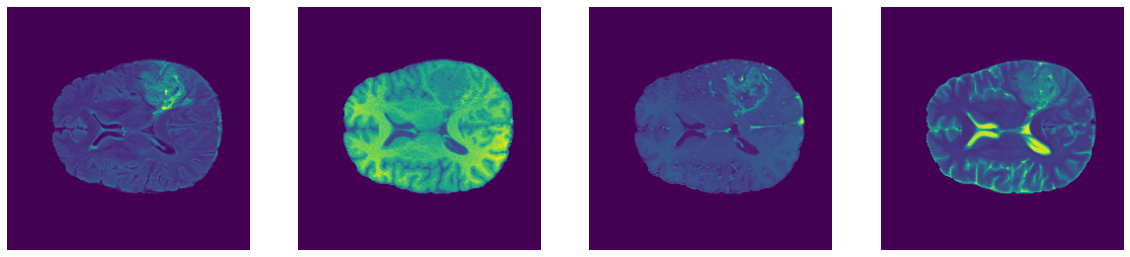

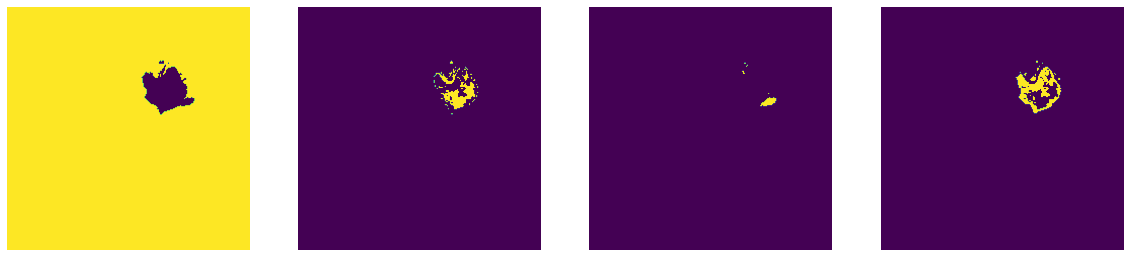

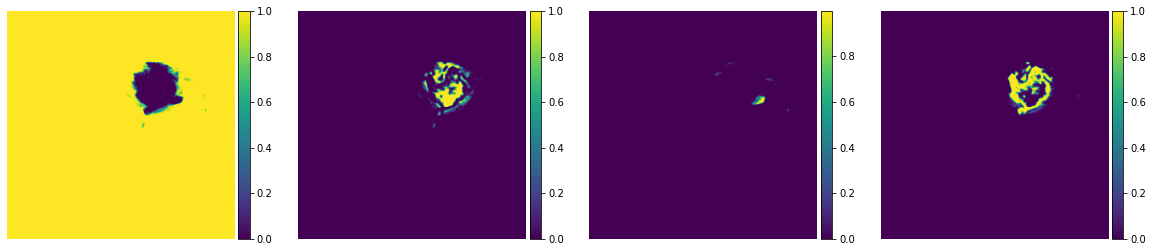

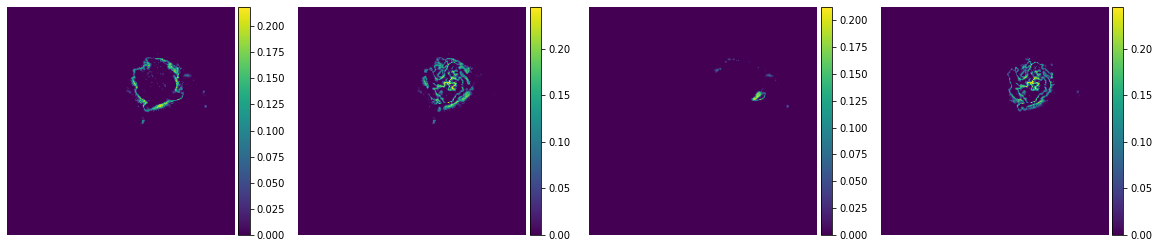

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

img_idx = 1

plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = testSet[img_idx][0][:,:,i]
    plt.subplot(1,4,1+i)
    ax = plt.gca()
    im = ax.imshow(img_np)
    ax.axis('off')
plt.show()

plt.subplots(1,4,figsize = (20,20))
for i in range(3):
    img_np = testSet[img_idx][1][:,:,i]
    plt.subplot(1,4,2+i)
    ax = plt.gca()
    im = ax.imshow(img_np)
    ax.axis('off')
plt.subplot(1,4,1)
img_np = testSet[img_idx][1][:,:,:]
img_np = torch.sum(img_np,axis=2)==0
ax = plt.gca()
im = ax.imshow(img_np)
ax.axis('off')
plt.show()

plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = mean[img_idx,i,:,:]
    plt.subplot(1,4,1+i)
    ax = plt.gca()
    im = ax.imshow(img_np)
    ax = plt.gca()
    ax.axis('off')
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.show()

plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = variance[img_idx,i,:,:]
    plt.subplot(1,4,1+i)
    ax = plt.gca()
    im = ax.imshow(img_np)
    ax = plt.gca()
    ax.axis('off')
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.show()